In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.special import ndtri
from scipy.stats import norm, lognorm

import pickle

In [2]:
fname = 'results_raw.pickle'
# Create a writer object
file = open(fname, 'rb')

# dump information
results_decision = pickle.load(file)

# close file
file.close()

fname = 'results_raw_50.pickle'
# Create a writer object
file = open(fname, 'rb')

# dump information
results_decision_50 = pickle.load(file)

# close file
file.close()

fname = 'results_raw_25.pickle'
# Create a writer object
file = open(fname, 'rb')

# dump information
results_decision_25 = pickle.load(file)

# close file
file.close()

In [5]:
df_25 = pd.concat(results_decision_25, names=['subject'])
df_50 = pd.concat(results_decision_50, names=['subject'])

In [ ]:
mu_theta, mu_Lambda, mu_tau, mu_alpha, mu_gamma = -1.32617141, 0.41613512, -1.37750916, -0.24550931, -0.13804112
sig_theta, sig_Lambda, sig_tau, sig_alpha, sig_gamma = 0.19484903, 0.71492692,  0.17975801, 0.08284753, 0.67868274
sig_error = 1.9222773
x0 = np.array([mu_theta, sig_theta, mu_Lambda, sig_Lambda, mu_tau, sig_tau, mu_alpha, sig_alpha, mu_gamma, sig_gamma, sig_error])

distro_estimates = {'mu':{'theta': x0[0], 'Lambda': x0[2], 'tau': x0[4], 'alpha': x0[6], 'gamma': x0[8]},
                         'sigma':{'theta': x0[1], 'Lambda': x0[3], 'tau': x0[5], 'alpha': x0[7],  'gamma': x0[9], 'error':x0[10]}}
distro_estimates_export = pd.DataFrame(distro_estimates)
distro_estimates_export['exp(mu)'] = np.exp(distro_estimates_export['mu'])
distro_estimates_export.to_csv('distro_estimates_errors_tau_repeat.csv')
distro_estimates_export


THETA_INIT = 0.42
LAMBDA_INIT = 1.6
TAU_INIT = .28
ALPHA_INIT = .9
GAMMA_INIT = .7
ERROR_INIT = 0

,mu,sigma,exp(mu)
theta,-1.326171,0.194849,0.265492
Lambda,0.416135,0.714927,1.516091
tau,-1.377509,0.179758,0.252206
alpha,-0.245509,0.082848,0.782306
gamma,-0.138041,0.678683,0.871063
error,NaN,1.922277,NaN


mu_theta, mu_Lambda, mu_tau, mu_alpha, mu_gamma      = -1.32617141, 0.41613512, -1.37750916, -0.24550931, -0.13804112
sig_theta, sig_Lambda, sig_tau, sig_alpha, sig_gamma = 0.19484903, 0.71492692,  0.17975801, 0.08284753, 0.67868274
sig_error = 1.9222773

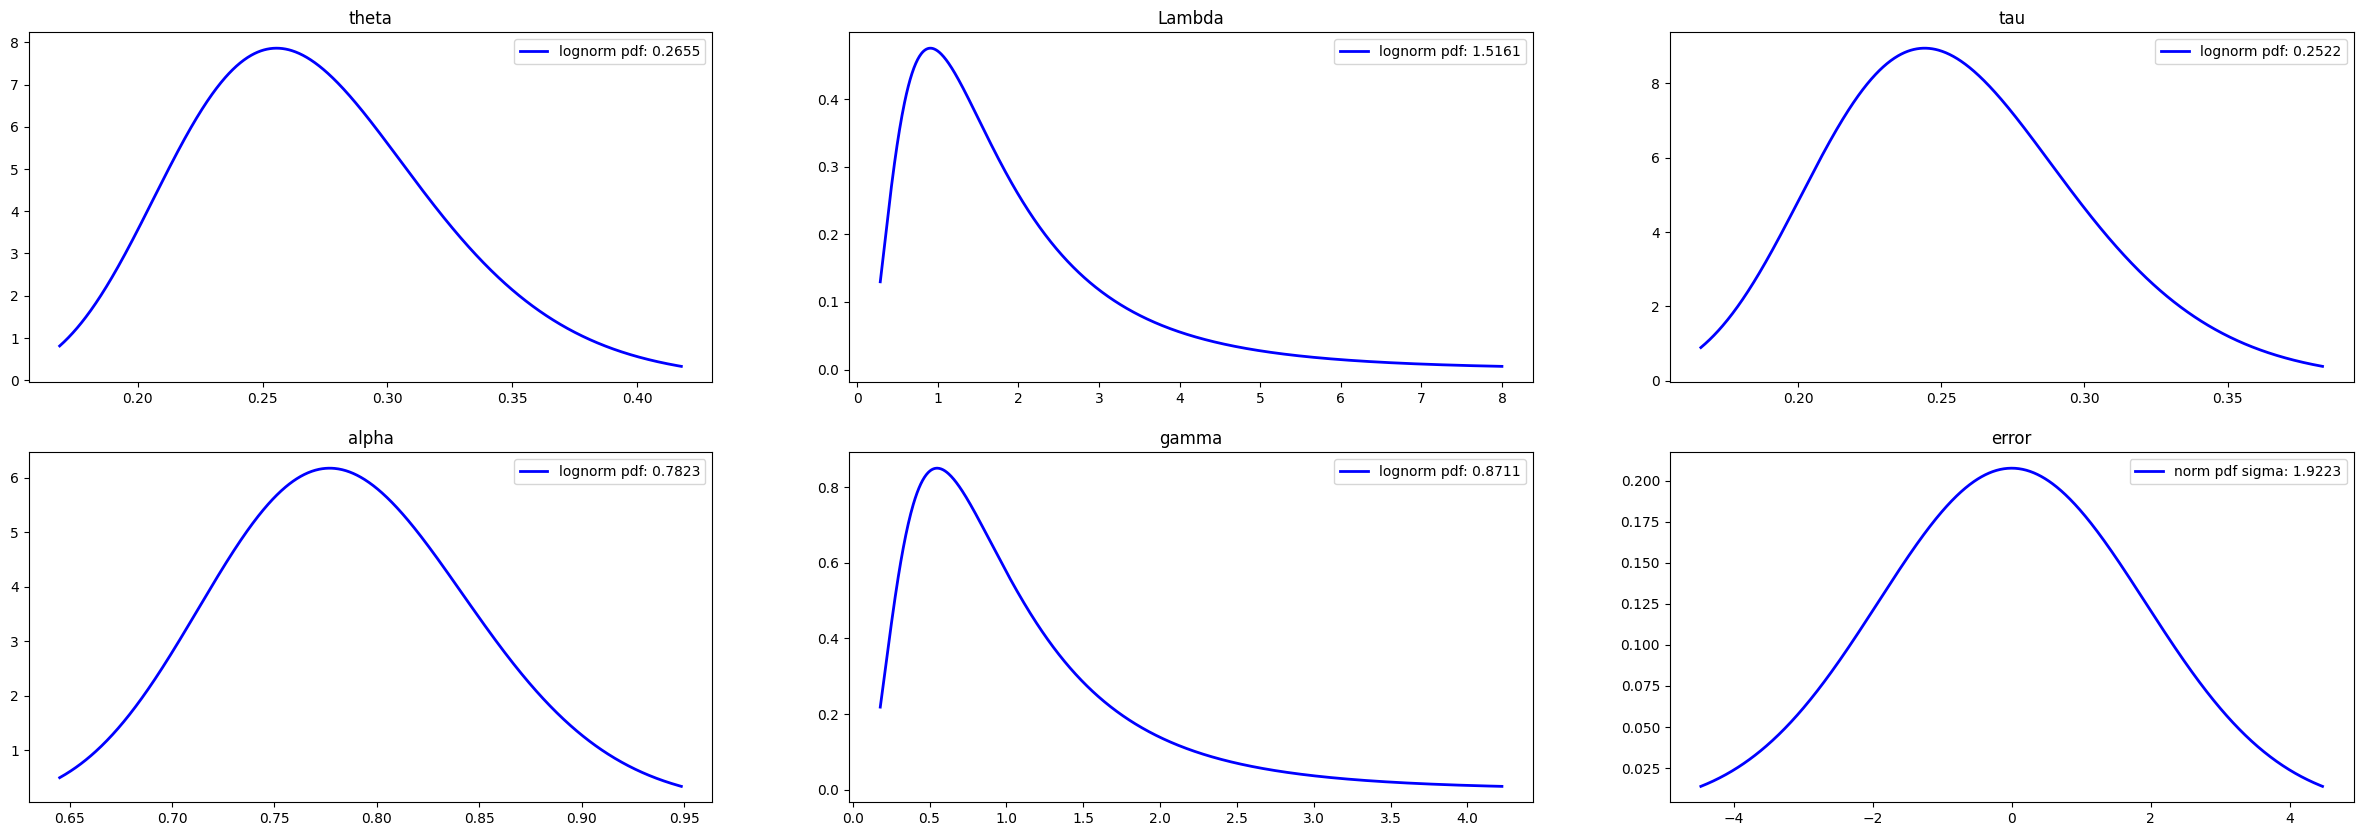

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(30,10))
for param,axis in zip(['theta', 'Lambda', 'tau', 'alpha', 'gamma','error'], [(0, 0), (0, 1), (0 ,2), (1, 0), (1, 1), (1, 2)]):
    if param=='error':
        scale = distro_estimates['sigma'][param]
        frozen_norm = norm(0, scale)
        x = np.linspace(norm.ppf(.01, 0, scale),norm.ppf(.99, 0, scale), 1000)
        axes[axis].plot(x, frozen_norm.pdf(x), 'b-', lw=2, alpha=1, label=f'norm pdf sigma: {scale:.4f}')
    else:
        s = distro_estimates['sigma'][param]
        scale = np.exp(distro_estimates['mu'][param])
        frozen_lognorm = lognorm(s, 0, scale)
        x = np.linspace(lognorm.ppf(.01, s, 0, scale),lognorm.ppf(.99, s, 0, scale), 1000)
        axes[axis].plot(x, frozen_lognorm.pdf(x), 'b-', lw=2, alpha=1, label=f'lognorm pdf: {scale:.4f}')
    axes[axis].legend()
    axes[axis].set_title(param)

plt.show()

In [13]:
results_decision_50.keys()
df = results_decision_50['11112']

In [14]:
import pymc as pm
import numpy as np
import pandas as pd
import aesara.tensor as at

# Load the investment decisions data
# data = pd.read_csv('../data/investment_decisions.csv')

# Assume df is your subject's DataFrame, and distro_estimates is as defined

FACTOR = 1/100
beta = 0.88

# Helper functions rewritten for Aesara tensors

def lognormal_pdf(value, mu, sigma):
    ''' Function to calculate the lognormal density'''
    shape  = sigma
    loc    = 0
    scale  = np.exp(mu)
    return lognorm.pdf(value, shape, loc, scale)

def normal_pdf(value, mu, sigma):
    ''' Function to calculate the lognormal density'''
    loc    = 0
    scale  = sigma
    return norm.pdf(value, loc, scale)

def calc_eta(green, red, theta, prob_ambi):
    # prob_ambi is always provided in your data
    return green + prob_ambi * theta

def calc_subj_prob(prob, gamma):
    return prob**gamma / (prob**gamma + (1 - prob)**gamma)**(1/gamma)

def calc_subj_values(x, Lambda, alpha, beta):
    return at.switch(x >= 0, x**alpha, -Lambda * (-x)**beta)

def calc_pt_utility(gain, loss, prob_win, prob_loss, theta, Lambda, alpha, beta, gamma, prob_ambi):
    prob_g = at.clip(calc_eta(prob_win, prob_loss, theta, prob_ambi), 0, 1)
    prob_l = at.clip(calc_eta(prob_loss, prob_win, 1-theta, prob_ambi), 0, 1)
    u = (
        calc_subj_values(gain, Lambda, alpha, beta) * calc_subj_prob(prob_g, gamma) +
        calc_subj_values(loss, Lambda, alpha, beta) * calc_subj_prob(prob_l, gamma)
    )
    return u

def calc_prob_invest(utility, tau, error):
    return 1 / (1 + at.exp(-tau * (utility - error)))



In [ ]:
# Prepare data

gain      = df['gain'].values * FACTOR
loss      = df['loss'].values * FACTOR
prob_win  = df['prob_win'].values
prob_loss = df['prob_loss'].values
prob_ambi = df['prob_ambi'].values
invest    = df['invest'].values.astype(int)



In [ ]:
import time

start_time = time.time()

initvals = {
    'theta': THETA_INIT,
    'Lambda': LAMBDA_INIT,
    'tau': TAU_INIT,
    'alpha': ALPHA_INIT,
    'gamma': GAMMA_INIT,
    'error': ERROR_INIT
}


with pm.Model() as model:
    # Priors
    theta  = pm.Lognormal('theta', mu=distro_estimates['mu']['theta'], sigma=distro_estimates['sigma']['theta'])
    Lambda = pm.Lognormal('Lambda', mu=distro_estimates['mu']['Lambda'], sigma=distro_estimates['sigma']['Lambda'])
    tau    = pm.Lognormal('tau', mu=distro_estimates['mu']['tau'], sigma=distro_estimates['sigma']['tau'])
    alpha  = pm.Lognormal('alpha', mu=distro_estimates['mu']['alpha'], sigma=distro_estimates['sigma']['alpha'])
    gamma  = pm.Lognormal('gamma', mu=distro_estimates['mu']['gamma'], sigma=distro_estimates['sigma']['gamma'])
    error  = pm.Normal('error', mu=0, sigma=distro_estimates['sigma']['error'])

    # Utility and probability
    utility = calc_pt_utility(
        gain=gain,
        loss=loss,
        prob_win=prob_win,
        prob_loss=prob_loss,
        theta=theta,
        Lambda=Lambda,
        alpha=alpha,
        beta=beta,
        gamma=gamma,
        prob_ambi=prob_ambi
    )
    p = calc_prob_invest(utility, tau, error)

    # Likelihood
    invest_obs = pm.Bernoulli('invest_obs', p=p, observed=invest)

    # Sample from the posterior
    trace = pm.sample(5000, tune=5000, target_accept=0.9, chains=4, initvals=initvals, return_inferencedata=True)
# Save the trace object for later analysis

# You can now analyze the trace object for posterior inference
pymc_time = time.time() - start_time

/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_45645/2169198279.py:37: RuntimeWarning: invalid value encountered in power
  return at.switch(x >= 0, x**alpha, -Lambda * (-x)**beta)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, Lambda, tau, alpha, gamma, error]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 58 seconds.


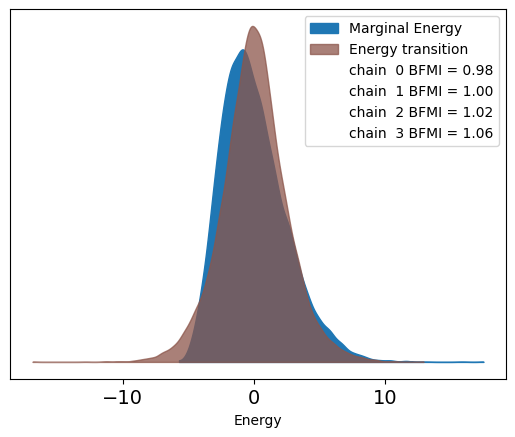

X axis values (energy):
[27.26439027 29.70224687 32.390589   ... 28.37695589 30.16003871
 27.09335969]


In [50]:
import arviz as az

az.plot_energy(trace)
plt.xlabel("Energy")
energy = trace.sample_stats["energy"].values.flatten()
plt.xticks(np.round(np.linspace(-10, 10, num=3), 2))
plt.show()
print("X axis values (energy):")
print(energy)

array([[<Axes: title={'center': 'error'}>,
        <Axes: title={'center': 'error'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>],
       [<Axes: title={'center': 'Lambda'}>,
        <Axes: title={'center': 'Lambda'}>],
       [<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'gamma'}>]], dtype=object)

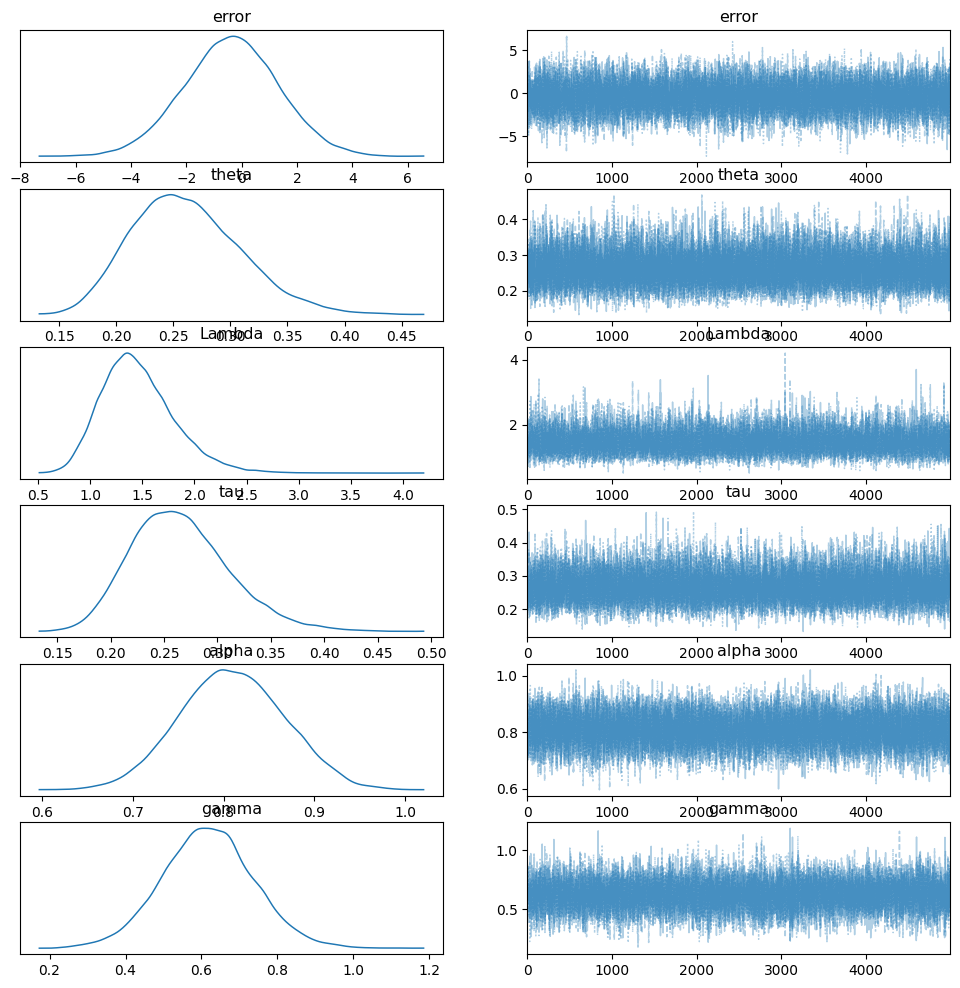

In [51]:
az.plot_trace(trace, combined=True)


In [54]:
# Extract posterior means for each parameter from the trace
summary = az.summary(trace, var_names=["theta", "Lambda", "tau", "alpha", "gamma", "error"])
print(summary)

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta   0.262  0.048   0.174    0.349      0.000    0.000   20846.0   13507.0   
Lambda  1.460  0.352   0.832    2.109      0.003    0.003   13768.0   12741.0   
tau     0.266  0.046   0.182    0.352      0.000    0.000   18411.0   12875.0   
alpha   0.809  0.057   0.700    0.914      0.000    0.000   13575.0   12866.0   
gamma   0.616  0.121   0.383    0.841      0.001    0.001   16008.0   10872.0   
error  -0.374  1.708  -3.582    2.842      0.012    0.013   19541.0   13767.0   

        r_hat  
theta     1.0  
Lambda    1.0  
tau       1.0  
alpha     1.0  
gamma     1.0  
error     1.0  


,trial_num,response_time,invest,prob_win,prob_loss,prob_ambi,gain,loss,lottery_trial_num,group_responsibility
0,1,13.293310,1.0,0.2,0.3,0.5,7000.0,-3000.0,29.0,0.0
1,2,5.902034,0.0,0.2,0.0,0.8,10000.0,-6000.0,46.0,0.0
2,3,7.698850,1.0,0.4,0.3,0.3,4000.0,-2000.0,19.0,0.0
3,4,10.992664,0.0,0.5,0.0,0.5,3000.0,-7000.0,3.0,0.0
4,5,7.219638,1.0,0.0,0.2,0.8,5000.0,-1000.0,43.0,0.0
5,6,8.089982,0.0,0.1,0.4,0.5,8000.0,-3000.0,28.0,0.0
6,7,6.801851,0.0,0.4,0.0,0.6,8000.0,-10000.0,37.0,0.0
7,8,5.957266,0.0,0.1,0.1,0.8,8000.0,-4000.0,45.0,0.0
8,9,7.474308,1.0,0.4,0.1,0.5,7000.0,-5000.0,31.0,0.0
9,10,5.517789,0.0,0.2,0.1,0.7,5000.0,-4000.0,41.0,0.0
